In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchvision.models.segmentation import deeplabv3_resnet50

from pytorch_lightning import loggers as pl_loggers
from math import sqrt
import albumentations as A

In [3]:
class EyesDataset(Dataset):
    
    def __init__(self, im_path, mask_path, aug=False):
        self.im_pathes = os.listdir(im_path)
        self.im_pathes = [os.path.join(im_path, i) for i in self.im_pathes]#[:50]
        self.mask_pathes = os.listdir(mask_path)
        self.mask_pathes = [os.path.join(mask_path, i) for i in self.mask_pathes]#[:50]
        self.aug = aug
        
    def __len__(self):
        return len(self.im_pathes)
        
    def __getitem__(self, idx):
        transform = transforms.ToTensor()
        img = plt.imread(self.im_pathes[idx])
        mask = plt.imread(self.mask_pathes[idx])
        if len(mask.shape) > 2:
            mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        
        # augmentations
        if self.aug:
            aug = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomGamma(p=0.2, gamma_limit=(80, 120)),
                A.RandomContrast(p=0.2, limit=0.2),
                A.RandomBrightness(p=0.2, limit=0.2),
                A.Blur(p=0.05, blur_limit=1),
                A.CLAHE(p=0.1, clip_limit=2.0, tile_grid_size=(5, 5)),
                A.GridDistortion(p=0.3, num_steps=6, distort_limit=0.2),
                A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=0, rotate_limit=15)])
            augmented = aug(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        img = transform(img / 255.).type('torch.FloatTensor')
        mask = transform(mask)
        return img, mask

In [10]:
class LitDeepLabV3(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.model = deeplabv3_resnet50(pretrained=False)
        # replace last layer
        self.model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
        self.model.classifier.add_module = nn.Sigmoid()
    
    def forward(self, x):
        output = self.model(x)
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)['out']
        loss = F.binary_cross_entropy(outputs, masks)
        
#         tensorboard = self.logger.experiment
#         tensorboard.add_scalar(scalar_value=loss, tag='train_loss')
        
        result = pl.TrainResult(minimize=loss)
        result.log('train_loss', loss, on_epoch=True)
        return result
    
    def test_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)['out']
        loss = F.binary_cross_entropy(outputs, masks)
        result = pl.EvalResult()
        result.log('test_loss', loss, prog_bar=True, logger=False)
        return result
    
    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)['out']
        loss = F.binary_cross_entropy(outputs, masks)
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_loss', loss, prog_bar=True)
        return {'checkpoint_on':loss, 'val_loss':loss}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard = self.logger.experiment
        tensorboard.add_scalar(scalar_value=avg_loss, tag='avg_val_loss')
        return {'checkpoint_on':avg_loss, 'val_loss':avg_loss}
    
    def train_dataloader(self):
        im_path = 'train/image/0'
        mask_path = 'train/mask/0'
        train_dataset = EyesDataset(im_path, mask_path, aug=True)
        train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True, num_workers=8)
        return train_loader
    
    def test_dataloader(self):
        im_path = 'test/image/0'
        mask_path = 'test/mask/0'
        test_dataset = EyesDataset(im_path, mask_path)
        test_loader = DataLoader(dataset=test_dataset, batch_size=8, num_workers=8)
        return test_loader
    
    def val_dataloader(self):
        im_path = 'validation/image/0'
        mask_path = 'validation/mask/0'
        val_dataset = EyesDataset(im_path, mask_path)
        val_loader = DataLoader(dataset=val_dataset, batch_size=8, num_workers=8)
        return val_loader

In [11]:
lr_monitor = pl.callbacks.lr_logger.LearningRateLogger(logging_interval='step')
trainer = pl.Trainer(fast_dev_run=False, max_epochs=10, callbacks=[lr_monitor])
model = LitDeepLabV3()
trainer.fit(model)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/oleg/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
/home/oleg/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type      | Params
------------------------------------
0 | model | DeepLabV3 | 39 M  


/home/oleg/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


1

In [12]:
trainer.test()

/home/oleg/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.0311)}
--------------------------------------------------------------------------------



[{'test_loss': 0.031085392460227013}]

In [12]:
im_path = 'train/image/0'
mask_path = 'train/mask/0'
im_pathes = [os.path.join(im_path, i) for i in os.listdir(im_path)]
mask_pathes = [os.path.join(mask_path, i) for i in os.listdir(mask_path)]

In [13]:
im = plt.imread(im_pathes[0])
msk = plt.imread(mask_pathes[0])

In [145]:
?A.CLAHE

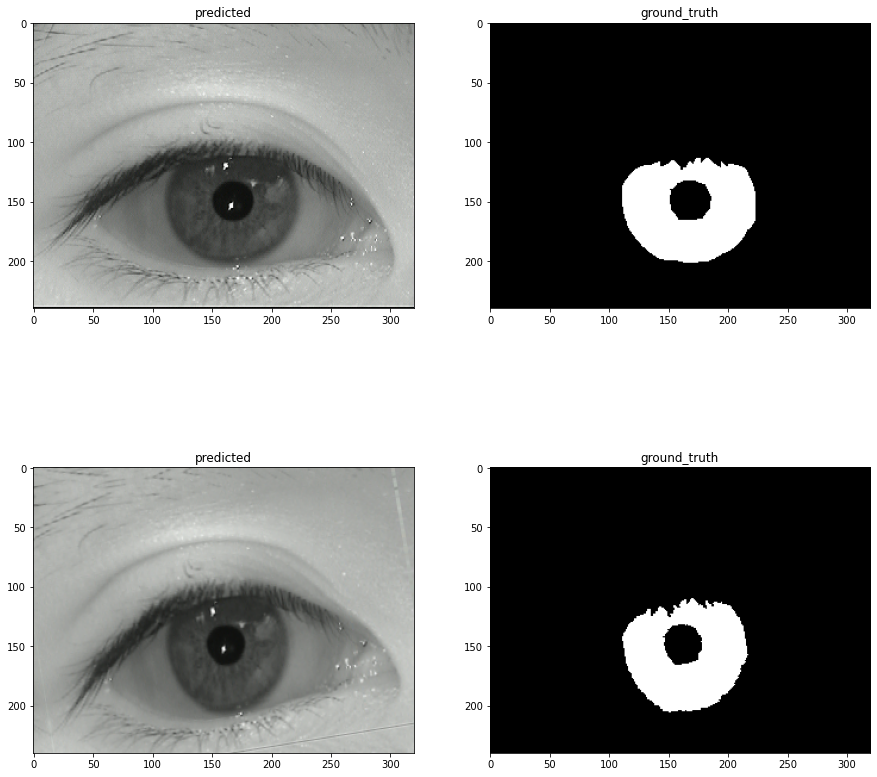

In [158]:
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomGamma(p=0.2, gamma_limit=(80, 120)),
    A.RandomContrast(p=0.2, limit=0.2),
    A.RandomBrightness(p=0.2, limit=0.2),
    A.Blur(p=0.05, blur_limit=1),
    A.CLAHE(p=0.1, clip_limit=2.0, tile_grid_size=(5, 5)),
    A.GridDistortion(p=0.3, num_steps=6, distort_limit=0.2),
    A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=0, rotate_limit=15)])

augmented = aug(image=im, mask=msk)

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0, 0].set_title('predicted')
ax[0, 0].imshow(im, cmap='gray')
ax[0, 1].set_title('ground_truth')
ax[0, 1].imshow(msk, cmap='gray');
ax[1, 0].set_title('predicted')
ax[1, 0].imshow(augmented['image'], cmap='gray')
ax[1, 1].set_title('ground_truth')
ax[1, 1].imshow(augmented['mask'], cmap='gray');